<a href="https://colab.research.google.com/github/dolmani38/Summary2/blob/main/en_multi-discriminator%20GAN%201008.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# English Multi-Discriminator GAN


ABSTRACT

----


#4. Implementation


## 4.1 기본 설정...

In [1]:
if True:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!pip install keybert
!pip3 install transformers
!pip3 install sentence-transformers

#!pip install sentence-transformers

In [3]:
import matplotlib.pyplot as plt
# set seeds for reproducability
from numpy.random import seed
#seed(1)

import pandas as pd
import numpy as np
import string, os 

import urllib.request
import nltk
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

logout = True

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [5]:
# Print iterations progress
class ProgressBar:

    def __init__(self,total=20, prefix = '', suffix = '', decimals = 1, length = 20, fill = '|', printEnd = "\r"):
        self.total = total
        self.prefix = prefix
        self.suffix = suffix
        self.decimals = decimals
        self.length = length
        self.fill = fill
        self.printEnd = printEnd
        self.ite = 0
        self.back_filledLength = 0

    def printProgress(self,iteration, text):
        self.ite += iteration
        percent = ("{0:." + str(self.decimals) + "f}").format(100 * (self.ite / float(self.total)))
        filledLength = int(self.length * self.ite // self.total)
        bar = self.fill * filledLength + '.' * (self.length - filledLength)
        if filledLength > self.back_filledLength or percent == 100:
            if logout:
                print(f'\r{self.prefix} |{bar}| {percent}% {self.suffix}  {text}', end="", flush=True)
            # Print New Line on Complete
            if self.ite == self.total: 
                if logout:
                    print()
        self.back_filledLength = filledLength    

In [6]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

##4.2 Grammar Discriminator Class

In [7]:
from transformers import BertTokenizer, BertTokenizerFast,AutoTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split

import time
import random
import datetime
import pickle

# 간단한 전처리
def clean_text(txt):
    txt = txt.replace('\n',' ')
    txt = txt.replace('\r',' ')    
    txt = txt.replace('=','')
    txt = txt.replace('\"','')   
    txt = txt.replace('\'','')
    #txt = txt.replace(',','')
    txt = txt.replace('..','')
    txt = txt.replace('...','')
    txt = txt.replace(' .','.')
    txt = txt.replace('.','. ')
    txt = txt.replace('  ',' ')
    txt = txt.replace('  ',' ')    
    txt = txt.replace('  ',' ')   
    txt = txt.replace('  ',' ')           
    txt = txt.replace('  ',' ')
    txt = txt.replace('  ',' ')    
    txt = txt.replace('  ',' ')   
    txt = txt.replace('  ',' ')             
    return txt.strip()

def shuffling(txt):
    txt_list = txt.split(' ')
    random.shuffle(txt_list)
    return ' '.join(txt_list)

def collect_training_dataset_for_grammar_discriminator(sentences_dataset):

    sentences = []
    labels = []

    for txtss in sentences_dataset:
        txtss = clean_text(txtss)
        txts = txtss.strip().split('.')
        for txt in txts:  
            txt = txt.strip()
            if len(txt) > 10:
                #ko_grammar_dataset.append([txt,1])
                txt = txt.replace('.','')
                tf = random.choice([True,False])
                # 정상 또는 비정상 둘중에 하나만 데이터셋에 추가
                if (tf):
                    sentences.append(txt) # '.'의 위치를 보고 True, False를 판단 하기 땜에...
                    labels.append(1)
                else:
                    sentences.append(shuffling(txt))
                    labels.append(0)

    return sentences,labels

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

class Grammar_Discriminator:


    def __init__(self, pretraoned_kobert_model_name='bert-base-v2', input_dir=None):

        if input_dir is None:
            self.tokenizer = BertTokenizerFast.from_pretrained(pretraoned_kobert_model_name)
            self.discriminator = BertForSequenceClassification.from_pretrained(
                                    pretraoned_kobert_model_name, # Use the 12-layer BERT model, with an uncased vocab.
                                    num_labels = 2, # The number of output labels--2 for binary classification.
                                                    # You can increase this for multi-class tasks.   
                                    output_attentions = False, # Whether the model returns attentions weights.
                                    output_hidden_states = False, # Whether the model returns all hidden-states.
                                )            
        else:
            self.__load_model(input_dir)




    def set_dataset(self, sentences,labels):
        # Print the original sentence.
        print(' Original: ', sentences[0])

        # Tokenize all of the sentences and map the tokens to thier word IDs.
        input_ids = []
        attention_masks = []

        # For every sentence...
        for i, sent in enumerate(sentences):
            print(f'\r Tokenize {i+1}/{len(sentences)}', end="", flush=True)            
            # `encode_plus` will:
            #   (1) Tokenize the sentence.
            #   (2) Prepend the `[CLS]` token to the start.
            #   (3) Append the `[SEP]` token to the end.
            #   (4) Map tokens to their IDs.
            #   (5) Pad or truncate the sentence to `max_length`
            #   (6) Create attention masks for [PAD] tokens.
            encoded_dict = self.tokenizer.encode_plus(
                                sent,                      # Sentence to encode.
                                add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                max_length = 64,           # Pad & truncate all sentences.
                                pad_to_max_length = True,
                                return_attention_mask = True,   # Construct attn. masks.
                                return_tensors = 'pt',     # Return pytorch tensors.
                                truncation = True,
                        )
            
            # Add the encoded sentence to the list.    
            input_ids.append(encoded_dict['input_ids'])
            
            # And its attention mask (simply differentiates padding from non-padding).
            attention_masks.append(encoded_dict['attention_mask'])

        # Convert the lists into tensors.
        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)
        labels = torch.tensor(labels)

        # Print sentence 0, now as a list of IDs.
        print('Original: ', sentences[0])
        print('Token IDs:', input_ids[0])

        # Training & Validation Split
        # Divide up our training set to use 90% for training and 10% for validation.

        # Combine the training inputs into a TensorDataset.
        dataset = TensorDataset(input_ids, attention_masks, labels)

        # Create a 90-10 train-validation split.

        # Calculate the number of samples to include in each set.
        train_size = int(0.9 * len(dataset))
        val_size = len(dataset) - train_size

        # Divide the dataset by randomly selecting samples.
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

        print('{:>5,} training samples'.format(train_size))
        print('{:>5,} validation samples'.format(val_size))

        # The DataLoader needs to know our batch size for training, so we specify it 
        # here. For fine-tuning BERT on a specific task, the authors recommend a batch 
        # size of 16 or 32.
        self.batch_size = 32

        # Create the DataLoaders for our training and validation sets.
        # We'll take training samples in random order. 
        self.train_dataloader = DataLoader(
                    train_dataset,  # The training samples.
                    sampler = RandomSampler(train_dataset), # Select batches randomly
                    batch_size = self.batch_size # Trains with this batch size.
                )

        # For validation the order doesn't matter, so we'll just read them sequentially.
        self.validation_dataloader = DataLoader(
                    val_dataset, # The validation samples.
                    sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                    batch_size = self.batch_size # Evaluate with this batch size.
                )        


    def train(self,epochs=4):
        # Tell pytorch to run this model on the GPU.
        self.discriminator.cuda()

        # Get all of the model's parameters as a list of tuples.
        params = list(self.discriminator.named_parameters())

        print('The BERT model has {:} different named parameters.\n'.format(len(params)))

        print('==== Embedding Layer ====\n')

        for p in params[0:5]:
            print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

        print('\n==== First Transformer ====\n')

        for p in params[5:21]:
            print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

        print('\n==== Output Layer ====\n')

        for p in params[-4:]:
            print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))  

        # Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
        # I believe the 'W' stands for 'Weight Decay fix"
        self.optimizer = AdamW(self.discriminator.parameters(),
                        lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                        eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                        )

        # Number of training epochs. The BERT authors recommend between 2 and 4. 
        # We chose to run for 4, but we'll see later that this may be over-fitting the
        # training data.
        #epochs = 2

        # Total number of training steps is [number of batches] x [number of epochs]. 
        # (Note that this is not the same as the number of training samples).
        total_steps = len(self.train_dataloader) * epochs

        # Create the learning rate scheduler.
        scheduler = get_linear_schedule_with_warmup(self.optimizer, 
                                                    num_warmup_steps = 0, # Default value in run_glue.py
                                                    num_training_steps = total_steps)
            
        # This training code is based on the `run_glue.py` script here:
        # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

        # Set the seed value all over the place to make this reproducible.
        seed_val = 42

        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        torch.cuda.manual_seed_all(seed_val)

        # We'll store a number of quantities such as training and validation loss, 
        # validation accuracy, and timings.
        training_stats = []

        # Measure the total training time for the whole run.
        total_t0 = time.time()

        # For each epoch...
        for epoch_i in range(0, epochs):
            
            # ========================================
            #               Training
            # ========================================
            
            # Perform one full pass over the training set.

            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
            print('Training...')

            # Measure how long the training epoch takes.
            t0 = time.time()

            # Reset the total loss for this epoch.
            total_train_loss = 0

            # Put the model into training mode. Don't be mislead--the call to 
            # `train` just changes the *mode*, it doesn't *perform* the training.
            # `dropout` and `batchnorm` layers behave differently during training
            # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
            self.discriminator.train()

            # For each batch of training data...
            for step, batch in enumerate(self.train_dataloader):

                # Progress update every 40 batches.
                if step % 40 == 0 and not step == 0:
                    # Calculate elapsed time in minutes.
                    elapsed = format_time(time.time() - t0)
                    
                    # Report progress.
                    print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(self.train_dataloader), elapsed))

                # Unpack this training batch from our dataloader. 
                #
                # As we unpack the batch, we'll also copy each tensor to the GPU using the 
                # `to` method.
                #
                # `batch` contains three pytorch tensors:
                #   [0]: input ids 
                #   [1]: attention masks
                #   [2]: labels 
                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device)

                # Always clear any previously calculated gradients before performing a
                # backward pass. PyTorch doesn't do this automatically because 
                # accumulating the gradients is "convenient while training RNNs". 
                # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
                self.discriminator.zero_grad()        

                # Perform a forward pass (evaluate the model on this training batch).
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # It returns different numbers of parameters depending on what arguments
                # arge given and what flags are set. For our useage here, it returns
                # the loss (because we provided labels) and the "logits"--the model
                # outputs prior to activation.
                outputs = self.discriminator(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask, 
                                    labels=b_labels)
                loss, logits = outputs.loss, outputs.logits
                # Accumulate the training loss over all of the batches so that we can
                # calculate the average loss at the end. `loss` is a Tensor containing a
                # single value; the `.item()` function just returns the Python value 
                # from the tensor.
                total_train_loss += loss.item()

                # Perform a backward pass to calculate the gradients.
                loss.backward()

                # Clip the norm of the gradients to 1.0.
                # This is to help prevent the "exploding gradients" problem.
                torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), 1.0)

                # Update parameters and take a step using the computed gradient.
                # The optimizer dictates the "update rule"--how the parameters are
                # modified based on their gradients, the learning rate, etc.
                self.optimizer.step()

                # Update the learning rate.
                scheduler.step()

            # Calculate the average loss over all of the batches.
            avg_train_loss = total_train_loss / len(self.train_dataloader)            
            
            # Measure how long this epoch took.
            training_time = format_time(time.time() - t0)

            print("")
            print("  Average training loss: {0:.2f}".format(avg_train_loss))
            print("  Training epcoh took: {:}".format(training_time))
                
            # ========================================
            #               Validation
            # ========================================
            # After the completion of each training epoch, measure our performance on
            # our validation set.

            print("")
            print("Running Validation...")

            t0 = time.time()

            # Put the model in evaluation mode--the dropout layers behave differently
            # during evaluation.
            self.discriminator.eval()

            # Tracking variables 
            total_eval_accuracy = 0
            total_eval_loss = 0
            nb_eval_steps = 0

            # Evaluate data for one epoch
            for batch in self.validation_dataloader:
                
                # Unpack this training batch from our dataloader. 
                #
                # As we unpack the batch, we'll also copy each tensor to the GPU using 
                # the `to` method.
                #
                # `batch` contains three pytorch tensors:
                #   [0]: input ids 
                #   [1]: attention masks
                #   [2]: labels 
                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device)
                
                # Tell pytorch not to bother with constructing the compute graph during
                # the forward pass, since this is only needed for backprop (training).
                with torch.no_grad():        

                    # Forward pass, calculate logit predictions.
                    # token_type_ids is the same as the "segment ids", which 
                    # differentiates sentence 1 and 2 in 2-sentence tasks.
                    # The documentation for this `model` function is here: 
                    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                    # Get the "logits" output by the model. The "logits" are the output
                    # values prior to applying an activation function like the softmax.
                    outputs = self.discriminator(b_input_ids, 
                                        token_type_ids=None, 
                                        attention_mask=b_input_mask,
                                        labels=b_labels)
                loss, logits = outputs.loss, outputs.logits
                # Accumulate the validation loss.
                total_eval_loss += loss.item()

                # Move logits and labels to CPU
                logits = logits.detach().cpu().numpy()
                label_ids = b_labels.to('cpu').numpy()

                # Calculate the accuracy for this batch of test sentences, and
                # accumulate it over all batches.
                total_eval_accuracy += flat_accuracy(logits, label_ids)
                

            # Report the final accuracy for this validation run.
            avg_val_accuracy = total_eval_accuracy / len(self.validation_dataloader)
            print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

            # Calculate the average loss over all of the batches.
            avg_val_loss = total_eval_loss / len(self.validation_dataloader)
            
            # Measure how long the validation run took.
            validation_time = format_time(time.time() - t0)
            
            print("  Validation Loss: {0:.2f}".format(avg_val_loss))
            print("  Validation took: {:}".format(validation_time))

            # Record all statistics from this epoch.
            training_stats.append(
                {
                    'epoch': epoch_i + 1,
                    'Training Loss': avg_train_loss,
                    'Valid. Loss': avg_val_loss,
                    'Valid. Accur.': avg_val_accuracy,
                    'Training Time': training_time,
                    'Validation Time': validation_time
                }
            )

        print("")
        print("Training complete!")

        print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
            

        return training_stats

    def save_model(self, output_dir = './model_save/'):
        # Create output directory if needed
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        print("Saving model to %s" % output_dir)

        # Save a trained model, configuration and tokenizer using `save_pretrained()`.
        # They can then be reloaded using `from_pretrained()`
        model_to_save = self.discriminator.module if hasattr(self.discriminator, 'module') else self.discriminator  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        self.tokenizer.save_pretrained(output_dir)

        # Good practice: save your training arguments together with the trained model
        # torch.save(args, os.path.join(output_dir, 'training_args.bin'))

    def __load_model(self, input_dir = './drive/MyDrive/Colab Notebooks/summary/en_grammar_check_model'):
        print('Loading BERT tokenizer...')
        self.tokenizer = BertTokenizerFast.from_pretrained(input_dir)
        self.discriminator = BertForSequenceClassification.from_pretrained(input_dir)

    def transfer_learning(self, sentences, train_for = True):
        
        input_ids = []
        attention_masks = []

        # For every sentence...
        for sent in sentences:
            # `encode_plus` will:
            #   (1) Tokenize the sentence.
            #   (2) Prepend the `[CLS]` token to the start.
            #   (3) Append the `[SEP]` token to the end.
            #   (4) Map tokens to their IDs.
            #   (5) Pad or truncate the sentence to `max_length`
            #   (6) Create attention masks for [PAD] tokens.
            encoded_dict = self.tokenizer.encode_plus(
                                sent,                      # Sentence to encode.
                                add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                max_length = 64,           # Pad & truncate all sentences.
                                pad_to_max_length = True,
                                return_attention_mask = True,   # Construct attn. masks.
                                return_tensors = 'pt',     # Return pytorch tensors.
                                truncation = True,
                        )
            # Add the encoded sentence to the list.    
            input_ids.append(encoded_dict['input_ids'])

            # And its attention mask (simply differentiates padding from non-padding).
            attention_masks.append(encoded_dict['attention_mask'])
        
        if train_for:
            b_labels = torch.ones(len(sentences),dtype=torch.long).to(device)
        else:
            b_labels = torch.zeros(len(sentences),dtype=torch.long).to(device)
        #print(b_labels)
        # Convert the lists into tensors.
        input_ids = torch.cat(input_ids, dim=0).to(device)
        attention_masks = torch.cat(attention_masks, dim=0).to(device)    
        #if str(discriminator1.device) == 'cpu':
        #    pass
        #else:
        #    input_ids = input_ids.to(device)
        #    attention_masks = attention_masks.to(device)        

        outputs = self.discriminator(input_ids, 
                            token_type_ids=None, 
                            attention_mask=attention_masks, 
                                labels=b_labels)

        #print(outputs)
        #return torch.sigmoid(outputs[0][:,1])
        #return outputs[0][:,1]
        return outputs['loss'], outputs['logits']


# 문법 discriminator 활용

In [8]:
g_discriminator = Grammar_Discriminator(input_dir = '/content/drive/MyDrive/Colab Notebooks/summary/en_grammar_model')

Loading BERT tokenizer...


In [9]:
txt = ['Her friends sadly never heard from her after they parted company.','Her friends sadly never from her after heard they parted company.']
g_discriminator.discriminator.to(device)
g_discriminator.transfer_learning(txt)

(tensor(2.1402, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor([[-5.8312,  5.9503],
         [ 2.0386, -2.2279]], device='cuda:0', grad_fn=<AddmmBackward>))

##4.3 Static similarity discriminator class

In [10]:
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
import scipy


class Similarity_Discriminator:
    '''
    _instance = None
    _embedder = None
    def __new__(cls,pre_trained_model_name='stsb-roberta-large'):
        if cls._instance is None:
            print('Creating Similarity_Discriminator object')
            cls._instance = super(Similarity_Discriminator, cls).__new__(cls)
            # Put any initialization here.
            cls._embedder = SentenceTransformer(pre_trained_model_name)
        return cls._instance

    '''

    def __init__(self,pre_trained_model_name='stsb-roberta-large'): #'roberta-large-nli-stsb-mean-tokens'):
        print('Creating Similarity_Discriminator object')
        # Put any initialization here.
        self._embedder = SentenceTransformer(pre_trained_model_name,device=device)  
        #self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)

    def encode(self,texts):
        return self._embedder.encode(texts,show_progress_bar=False)

    def similarity(self, query_text, org_text_emb):
        queries = nltk.sent_tokenize(query_text)
        query_embeddings = self._embedder.encode(queries,show_progress_bar=False)
        #query_embeddings = self._embedder.encode(queries,show_progress_bar=False)
        #print(queries)
        #print(org_text_emb)
        
        if len(query_embeddings) == 0:
            return 0.0

        cos_scores = scipy.spatial.distance.cdist(query_embeddings, org_text_emb, "cosine")
        similarity_score = 1.0 - np.mean(np.min(cos_scores,axis=1))
        '''
        for query, query_embedding in zip(queries, query_embeddings):
            distances = scipy.spatial.distance.cdist([query_embedding], [org_text_emb], "cosine")[0]
            results = zip(range(len(distances)), distances)
            for idx, distance in results:
                scores.append(1-distance)
        '''
        return similarity_score  
 

###4.3.1 영어 문장 유사도 pre-trained model 적용

In [11]:
#del s_discriminator

s_discriminator = Similarity_Discriminator()
#s_discriminator = Similarity_Discriminator()

Creating Similarity_Discriminator object


# ExtactiveSummarizer

In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
from nltk.tokenize import sent_tokenize
import numpy as np
import networkx as nx
import re
import torch
from torch import nn
from transformers import BertTokenizer, BertModel

In [13]:

class ExtactiveSummarizer:
    # 한국어의 경우, 'kykim/bert-kor-base'
    def __init__(self,model_name='bert-base-uncased'):
        
        #nltk.download('stopwords')
        nltk.download('punkt')

        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertModel.from_pretrained(model_name, return_dict=True, output_attentions=True)
        self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)

        # If there's a GPU available...
        if torch.cuda.is_available():    
            # Tell PyTorch to use the GPU.    
            self.device = torch.device("cuda")
        # If not...
        else:
            self.device = torch.device("cpu")

        self.model.to(self.device)
        #self.cos.to(self.device)
        
    def read_article(self,text):        
        sentences =[]        
        sentences = sent_tokenize(text)    
        for sentence in sentences:        
            sentence.replace("[^a-zA-Z0-9]"," ")     
        return sentences

    def sentence_similarity(self,sent1,sent2):

        sent_1_pooler_output = s_discriminator.encode([sent1])
        #print(sent_1_pooler_output)
        sent_2_pooler_output = s_discriminator.encode([sent2])
        '''
        tok_sent1 = self.tokenizer(sent1, return_tensors="pt")
        tok_sent2 = self.tokenizer(sent2, return_tensors="pt")
        tok_sent1.to(self.device)
        tok_sent2.to(self.device)
        outputs = self.model(**tok_sent1)
        sent_1_pooler_output = outputs.pooler_output

        outputs = self.model(**tok_sent2)
        sent_2_pooler_output = outputs.pooler_output
        '''
        cos_scores = scipy.spatial.distance.cdist(sent_1_pooler_output, sent_2_pooler_output, "cosine")
        return 1 - cos_scores[0] #self.cos(sent_1_pooler_output, sent_2_pooler_output) #.cpu().detach().numpy()

    def get_self_attention_weight(self,sentence):
        tok_sent = self.tokenizer(sentence, return_tensors="pt")
        tok_sent.to(self.device)
        outputs = self.model(**tok_sent)
        
        attentions = torch.stack(outputs.attentions)
        #attention = outputs[-1]  # Output includes attention weights when output_attentions=True
        last_attentions = attentions[11][0][11]
        #print(last_attentions.shape)
        tokens = [self.tokenizer.convert_ids_to_tokens(s) for s in tok_sent['input_ids'].tolist()[0]]
        #print(tokens)
        attention_map = []
        for i,token in enumerate(tokens):
            if token.startswith('##'):
                (ii,tt,s) = attention_map[-1]
                tt += token.replace('##','')
                s0 = torch.sum(last_attentions[:,i]).item()
                s1 = s if s > s0 else s0
                attention_map[len(attention_map)-1] = (ii,tt,s1)
            else:
                attention_map.append((i,token,torch.sum(last_attentions[:,i]).item()))
            
        return attention_map

    # Create similarity matrix among all sentences
    def build_similarity_matrix(self,sentences):
        #create an empty similarity matrix
        pooler_output = s_discriminator.encode(sentences)

        cos_scores = scipy.spatial.distance.cdist(pooler_output, pooler_output, "cosine")

        similarity_matrix = np.ones((len(sentences),len(sentences)))
        similarity_matrix = similarity_matrix - cos_scores
        #print(similarity_matrix)        
        '''
        for idx1 in range(len(sentences)):
            for idx2 in range(len(sentences)):
                if idx1!=idx2:
                    similarity_matrix[idx1][idx2] = self.sentence_similarity(sentences[idx1],sentences[idx2])
        '''      
        return similarity_matrix

    # Generate and return text summary
    def generate_summary(self,text,top_n,min_length=30):
        
        ft = []
        org_sentences = np.array(nltk.sent_tokenize(text))
        for txt in org_sentences:
            if len(txt) > min_length:
                ft.append(txt)
        text = ' '.join(ft)

        #stop_words = stopwords.words('english')
        summarize_text = []
        
        # Step1: read text and tokenize
        sentences = self.read_article(text)
        
        # Steo2: generate similarity matrix across sentences
        sentence_similarity_matrix = self.build_similarity_matrix(sentences)
        
        # Step3: Rank sentences in similarirty matrix
        sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_matrix)
        scores = nx.pagerank(sentence_similarity_graph)
        #print(scores)
        orderd = [(o,scores[o]) for o in scores.keys()]
        orderd.sort(key=lambda e: e[1],reverse=True)

        #print(orderd)

        top_n = top_n if len(orderd) > top_n else len(orderd)
        a = [orderd[i][0] for i in range(0,top_n)]
        a.sort()
        summ_text = " ".join([sentences[i] for i in a])

        '''
        #Step4: sort the rank and place top sentences
        ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)),reverse=True)
        
        #print(ranked_sentences)
        # Step 5: get the top n number of sentences based on rank    
        for i in range(top_n if top_n < len(ranked_sentences) else len(ranked_sentences)):
            summarize_text.append(ranked_sentences[i][1])
        
        orderd = [(o,s) for o,s in enumerate(scores)]
        orderd.sort(key=lambda e: e[1],reverse=True)
        top_n = top_n if len(orderd) > top_n else len(orderd)
        a = [orderd[i][0] for i in range(0,top_n)]
        a.sort()
        summ_text = " ".join([sentences[i] for i in a])
        '''
        # Step 6 : outpur the summarized version
        return summ_text,len(sentences)   # " ".join(summarize_text), len(sentences)  #

In [14]:
es = ExtactiveSummarizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
es.sentence_similarity('This IS expected if you are initializing from the checkpoint','This IS expected if you are initializing BertModel from the checkpoint')

array([0.75140336])

In [16]:
es.get_self_attention_weight('The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo Grand Forks and Jamestown to the hepatitis A virus in late September and early October.')

[(0, '[CLS]', 0.18557289242744446),
 (1, 'the', 0.07899213582277298),
 (2, 'bishop', 0.3666439354419708),
 (3, 'of', 0.05223364382982254),
 (4, 'the', 0.10034431517124176),
 (5, 'fargo', 0.0550147145986557),
 (6, 'catholic', 0.3552972078323364),
 (7, 'diocese', 0.11490436643362045),
 (8, 'in', 0.12254498898983002),
 (9, 'north', 0.009641865268349648),
 (10, 'dakota', 0.04165465384721756),
 (11, 'has', 0.11064591258764267),
 (12, 'exposed', 0.2776542901992798),
 (13, 'potentially', 0.10957956314086914),
 (14, 'hundreds', 0.1402682662010193),
 (15, 'of', 0.19087064266204834),
 (16, 'church', 0.38132524490356445),
 (17, 'members', 0.20232832431793213),
 (18, 'in', 0.20666250586509705),
 (19, 'fargo', 0.12040776759386063),
 (20, 'grand', 0.03221951425075531),
 (21, 'forks', 0.06993243098258972),
 (22, 'and', 0.13787443935871124),
 (23, 'jamestown', 0.29331332445144653),
 (24, 'to', 0.25634700059890747),
 (25, 'the', 0.23425814509391785),
 (26, 'hepatitis', 0.4447019398212433),
 (27, 'a', 0

# 4.4 Document source class

## CNN/Daily mail Sample data 수집

In [17]:
import pickle
if False:
    with open("/content/drive/MyDrive/Colab Notebooks/summary/data/dnn_daily_mail_sample.bin", "rb") as fp:
        dt = pickle.load(fp)
    sentences_dataset = dt[0]
    gold_summary = dt[1]

In [18]:
import tensorflow_datasets as tfds
if False:
    train_data, test_data = tfds.load(name="cnn_dailymail",split=(tfds.Split.TRAIN,tfds.Split.TEST),with_info=True)

In [19]:
if False:
    sentences_dataset = []
    gold_summary = []
    iterator = iter(train_data[1])
    cnt = 0
    for data in iterator:
        cnt += 1
        if cnt < 1000:
            sentences_dataset.append(data['article'].numpy().decode('UTF-8'))
            gold_summary.append(data['highlights'].numpy().decode('UTF-8'))
        else:
            break


In [20]:
import pickle
if False:
    with open("/content/drive/MyDrive/Colab Notebooks/summary/data/dnn_daily_mail_test.bin", "wb") as fp:
        pickle.dump([sentences_dataset,gold_summary],fp)


In [21]:
import pickle
with open("/content/drive/MyDrive/Colab Notebooks/summary/data/dnn_daily_mail_test.bin", "rb") as fp:
    dt = pickle.load(fp)
sentences_dataset = dt[0]
gold_summary = dt[1]

In [22]:
gold_summary[0]

'Experts question if  packed out planes are putting passengers at risk .\nU.S consumer advisory group says minimum space must be stipulated .\nSafety tests conducted on planes with more leg room than airlines offer .'

## 4.4.2 source class 구현

In [23]:
# 간단한 전처리
def __clean_text(txt):
    txt = txt.replace('\n',' ')
    txt = txt.replace('\r',' ')   
    txt = txt.replace('·',' ')       
    #txt = txt.replace('=','')
    #txt = txt.replace('\"','')   
    #txt = txt.replace('\'','')
    #txt = txt.replace(',','')
    #txt = txt.replace('..','')
    #txt = txt.replace('...','')
    txt = txt.replace('.',' ')
    txt = txt.replace('?',' ')
    txt = txt.replace('!',' ')        
    #txt = txt.replace('.','. ')
    txt = txt.replace('  ',' ')
    txt = txt.replace('  ',' ')    
    txt = txt.replace('  ',' ')   
    txt = txt.replace('  ',' ')           
    txt = txt.replace('  ',' ')
    txt = txt.replace('  ',' ')    
    txt = txt.replace('  ',' ')   
    txt = txt.replace('  ',' ')             
    return txt.strip()

def get_prepared_doc(txt):
    docs = []
    sentences = np.array(nltk.sent_tokenize(txt))
    for sen in sentences:
        docs.append(__clean_text(sen) +'.')
    return (' '.join(docs)).strip()

In [24]:


class Source:

    def __init__(self,full_text,org_text,delete_ending = False,attendtion_rate=0.3):
        self.full_text = full_text
        self.org_text = org_text
        self.delete_ending = delete_ending
        self.attendtion_rate = attendtion_rate

    def __crean_text(self, txt):
        txt = txt.replace('\n',' ')
        txt = txt.replace('\r',' ')    
        txt = txt.replace('=','')
        txt = txt.replace('\"','')   
        txt = txt.replace('\'','')
        txt = txt.replace(',','')
        txt = txt.replace('..','')
        txt = txt.replace('...','')
        txt = txt.replace(' .','.')
        txt = txt.replace('.','. ')
        txt = txt.replace('  ',' ')
        txt = txt.replace('  ',' ')    
        txt = txt.replace('  ',' ')   
        txt = txt.replace('  ',' ')           
        txt = txt.replace('  ',' ')
        txt = txt.replace('  ',' ')    
        txt = txt.replace('  ',' ')   
        txt = txt.replace('  ',' ')           
        return txt.strip()

    def get_similarity(self,sent):
        pooler_output = s_discriminator.encode([sent])
        cos_scores = scipy.spatial.distance.cdist(self.org_text_emb, pooler_output, "cosine")
        a = np.ones(cos_scores.shape) - cos_scores
        #print(cos_scores)
        #print(np.mean(cos_scores))
        return np.mean(a)-np.std(a) #self.cos(sent_1_pooler_output, sent_2_pooler_output) #.cpu().detach().numpy()

    def set_key_rate(self,s_discriminator):
        # full_text에 대한 처리...
        self.full_text = self.__crean_text(self.full_text.strip())
        self.full_sentences = np.array(nltk.sent_tokenize(self.full_text))
        self.s_discriminator = s_discriminator
        self.full_text_emb = self.s_discriminator.encode(self.full_sentences)   

        # original sentance, 즉 source sentence에 대한 처리
        self.org_text = self.__crean_text(self.org_text.strip())
        if logout:
            print('-'*50)
            print(self.org_text)
            print('-'*50)  

        # 두개 이상의 문장이 있는 경우, 중간 문자의 마침표를 지우고,
        # ' and'를 넣어서, 연결한다.
        self.org_sentences = np.array(nltk.sent_tokenize(self.org_text))
        self.org_text_emb = self.s_discriminator.encode(self.org_sentences)
        s = []
        for i,sents in enumerate(self.org_sentences):
            if sents.endswith('.') and i < len(self.org_sentences)-1:
                s.append(sents[:-1].strip() + " and")
            else:
                s.append(sents)
                #self.org_sentences[i] = sents[:-1].strip() + " and"
                #print(self.org_sentences[i])
        self.org_sentences = s
        #print(s)
        #print(self.org_sentences)
        # 하나의 문장을 token 단위로 잘라서 {index:token} dict을 만든다.
        # 또한, 각 token의 attention을 설정한다.
        self.org_term_set = (' '.join(self.org_sentences)).strip().split(' ')
        self.org_source_length = len(self.org_term_set)
        self.term_table = {}

        self.seps = []
        self.bias_table = {}
        #morp_table = {}
        aw = 0.0
        attentions = []
        # ~ and ~ 으로 재조합한 sentence에 대해서 self-attention을 구한다.
        self_attentions = es.get_self_attention_weight((' '.join(self.org_sentences)).strip())
        self_attentions_max = 0
        self_attentions_map = {}
        for index, word in enumerate(self.org_term_set):
            self.term_table[index] = word
            #attention = cosine_similarity(self.full_text,word)
            #attentions.append(attention)
            sa = 0
            for u in range(index,len(self_attentions)):
                if word.lower().replace('.','') == self_attentions[u][1]:
                    sa = self_attentions[u][2]
                    if sa > self_attentions_max:
                        self_attentions_max = sa

            self_attentions_map[index] = sa
            #print(f'{word} \t\t {attention:.4f} {sa:.4f}')
            
        #print('self_attentions_max',self_attentions_max)
        attentions = list(self_attentions_map.values())
        attentions.sort(reverse=True)
        #문장 전체 token의 30%에 attention을 준다.
        trs = attentions[int(len(attentions)*self.attendtion_rate + 0.5)]

        for index, word in enumerate(self.org_term_set):
            self.term_table[index] = word
            self.bias_table[index] = self_attentions_map[index] - trs #self_attentions_max
            #attention = self_attentions_map[index] #cosine_similarity(self.full_text,word)
            self.bias_table[index] = (0.0 if self.bias_table[index] > 0 else -1.0)
            #self.bias_table[index] = (self.bias_table[index] if self.bias_table[index] > 0 else -1.0)
            #if len(self.org_term_set) - 1 == index:
            #        self.bias_table[index] = 0.1
            '''
            if attention >= trs or index == len(self.org_term_set)-1:
                self.bias_table[index] = self_attentions_map[index] - trs #0.0 #attention
            else:
                self.bias_table[index] = -1.0 #attention #-cosine_similarity(self.full_text,word)
            '''
            '''
            if word.endswith(('.','?')):
                self.seps.append(index)
                if self.org_source_length - 1 == index:
                    pass
                else:
                    self.term_table[index] = combine_sentence(word)
            '''
            if logout:
                print(f'{index} \t {self_attentions_map[index]:.4f} \t {self.bias_table[index]} \t{word} ')            
        #print(list(self.bias_table.values()))
        # 또 다른 token 단위의 {index:token} dict을 만드는데, 이는 generator의 조합이
        # 문법적으로 부실할 경우, corrector가 보정할때 '~~고'의 중간 연결문을 
        # 부드럽게 만들기 위해 중간 문장의 '~다.'를 삭제한 dict에 해당한다.
        self.combination_table = {}
        for index, word in enumerate(self.org_term_set):
            self.combination_table[index] = word
            if index < len(self.org_term_set)-1: #중간 문장의 '~다.'를 삭제한다.
                if self.org_term_set[index].endswith('다.'):
                    self.combination_table[index] = word[0:len(word)-2]

        #print(self.combination_table)
        if len(self.term_table) >= 128:
            raise Exception("Too much sentence length.")

    def get_org_sample(self, num):
        return self.org_sentences[np.random.choice(len(self.org_sentences), num)]

    def get_source_embedded_code(self):
        return self.org_text_emb

    def get_random_text(self,rate=0.5):
        cnt = int(len(self.term_table) * rate)
        a = list(self.term_table.keys())
        b = np.random.choice(a, cnt)
        c = [fruit for fruit in a if fruit not in b]
        txt = []
        for i in c:
            txt.append(self.term_table[i])
        return ' '.join(txt).strip(), hash(tuple(b))

## N-Gram Similarity Comparison

https://gist.github.com/gaulinmp/da5825de975ed0ea6a24186434c24fe4

In [25]:
# Get Tuple algorithms 
import re
import math
import numpy as np
from itertools import chain
from collections import Counter
import nltk
from nltk.util import ngrams # This is the ngram magic.
from textblob import TextBlob

NGRAM = 4

re_sent_ends_naive = re.compile(r'[.\n]')
re_stripper_alpha = re.compile('[^a-zA-Z]+')
re_stripper_naive = re.compile('[^a-zA-Z\.\n]')

splitter_naive = lambda x: re_sent_ends_naive.split(re_stripper_naive.sub(' ', x))

sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

def get_tuples_nosentences(txt):
    """Get tuples that ignores all punctuation (including sentences)."""
    if not txt: return None
    #ng = ngrams(re_stripper_alpha.sub(' ', txt).split(), NGRAM)
    ng = ngrams(txt, NGRAM)
    return list(ng)

def get_tuples_manual_sentences(txt):
    """Naive get tuples that uses periods or newlines to denote sentences."""
    if not txt: return None
    sentences = (x.split() for x in splitter_naive(txt) if x)
    ng = (ngrams(x, NGRAM) for x in sentences if len(x) >= NGRAM)
    return list(chain(*ng))

def get_tuples_nltk_punkt_sentences(txt):
    """Get tuples that doesn't use textblob."""
    if not txt: return None
    sentences = (re_stripper_alpha.split(x) for x in sent_detector.tokenize(txt) if x)
    # Need to filter X because of empty 'words' from punctuation split
    ng = (ngrams(filter(None, x), NGRAM) for x in sentences if len(x) >= NGRAM)
    return list(chain(*ng))

def get_tuples_textblob_sentences(txt):
    """New get_tuples that does use textblob."""
    if not txt: return None
    tb = TextBlob(txt)
    ng = (ngrams(x.words, NGRAM) for x in tb.sentences if len(x.words) > NGRAM)
    return [item for sublist in ng for item in sublist]

def jaccard_distance(a, b):
    """Calculate the jaccard distance between sets A and B"""
    a = set(a)
    b = set(b)
    return 1.0 * len(a&b)/len(a|b)

def cosine_similarity_ngrams(a, b):
    vec1 = Counter(a)
    vec2 = Counter(b)
    
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    return float(numerator) / denominator


def test():
    paragraph = """It was the best of times, it was the worst of times.
               It was the age of wisdom? It was the age of foolishness!
               I first met Dr. Frankenstein in Munich; his monster was, presumably, at home."""
    print(paragraph)
    _ = get_tuples_nosentences(paragraph);print("Number of N-grams (no sentences):", len(_));_

    _ = get_tuples_manual_sentences(paragraph);print("Number of N-grams (naive sentences):", len(_));_

    _ = get_tuples_nltk_punkt_sentences(paragraph);print("Number of N-grams (nltk sentences):", len(_));_

    _ = get_tuples_textblob_sentences(paragraph);print("Number of N-grams (TextBlob sentences):", len(_));_

    a = get_tuples_nosentences("It was the best of times.")
    b = get_tuples_nosentences("It was the worst of times.")
    print("Jaccard: {}   Cosine: {}".format(jaccard_distance(a,b), cosine_similarity_ngrams(a,b)))

    a = get_tuples_nosentences("Above is a bad example of four-gram similarity.")
    b = get_tuples_nosentences("This is a better example of four-gram similarity.")
    print("Jaccard: {}   Cosine: {}".format(jaccard_distance(a,b), cosine_similarity_ngrams(a,b)))

    a = get_tuples_nosentences("Jaccard Index ignores repetition repetition repetition repetition repetition.")
    b = get_tuples_nosentences("Cosine similarity weighs repetition repetition repetition repetition repetition.")
    print("Jaccard: {}   Cosine: {}".format(jaccard_distance(a,b), cosine_similarity_ngrams(a,b)))
test()

It was the best of times, it was the worst of times.
               It was the age of wisdom? It was the age of foolishness!
               I first met Dr. Frankenstein in Munich; his monster was, presumably, at home.
Number of N-grams (no sentences): 214
Number of N-grams (naive sentences): 25
Number of N-grams (nltk sentences): 25
Number of N-grams (TextBlob sentences): 25
Jaccard: 0.6071428571428571   Cosine: 0.755742181606458
Jaccard: 0.6071428571428571   Cosine: 0.755742181606458
Jaccard: 0.23214285714285715   Cosine: 0.9208243668497166


In [26]:
def cosine_similarity(src_txt,trg_txt):
    try:
        if src_txt == None or src_txt.strip() == '':
            return 0.0
        if trg_txt == None or trg_txt.strip() == '':
            return 0.0

        a = get_tuples_nosentences(src_txt)
        b = get_tuples_nosentences(trg_txt)
        return cosine_similarity_ngrams(a,b)
    except Exception as ex:
        #print(src_txt,trg_txt)
        return 0.0

In [27]:
txt = """
The judge agreed with police that he would have been over the limit at the time his red Citroen hit Miss Titley’s blue Daihatsu Cuore on a road near Yarmouth, Isle of Wight, on October 11, 2013.
His phone records showed he was also texting around the time of the crash.
"""
s = Source(txt,txt)
s.set_key_rate(s_discriminator)


--------------------------------------------------
The judge agreed with police that he would have been over the limit at the time his red Citroen hit Miss Titley’s blue Daihatsu Cuore on a road near Yarmouth Isle of Wight on October 11 2013. His phone records showed he was also texting around the time of the crash.
--------------------------------------------------
0 	 0.1041 	 -1.0 	The 
1 	 0.0605 	 -1.0 	judge 
2 	 0.0378 	 -1.0 	agreed 
3 	 0.0191 	 -1.0 	with 
4 	 0.1374 	 -1.0 	police 
5 	 0.0261 	 -1.0 	that 
6 	 0.2585 	 0.0 	he 
7 	 0.0563 	 -1.0 	would 
8 	 0.0963 	 -1.0 	have 
9 	 0.3205 	 0.0 	been 
10 	 0.3426 	 0.0 	over 
11 	 0.1041 	 -1.0 	the 
12 	 0.4273 	 0.0 	limit 
13 	 0.0268 	 -1.0 	at 
14 	 0.1041 	 -1.0 	the 
15 	 0.0197 	 -1.0 	time 
16 	 0.3000 	 0.0 	his 
17 	 0.2042 	 -1.0 	red 
18 	 0.2403 	 0.0 	Citroen 
19 	 0.3920 	 0.0 	hit 
20 	 0.4246 	 0.0 	Miss 
21 	 0.0000 	 -1.0 	Titley’s 
22 	 0.1911 	 -1.0 	blue 
23 	 0.5122 	 0.0 	Daihatsu 
24 	 0.2876 	 0.0 

In [28]:
def besm(full_text,top_rank=2):
    '''
    ft = []
    org_sentences = np.array(nltk.sent_tokenize(full_text))
    for txt in org_sentences:
        if len(txt) > 30:
            ft.append(txt)
    full_text = ' '.join(ft)
    '''
    queries = nltk.sent_tokenize(full_text)
    src_sentences = nltk.sent_tokenize(full_text)
    query_embeddings = s_discriminator._embedder.encode(queries,show_progress_bar=False)
    full_text_embeddings = s_discriminator._embedder.encode(src_sentences,show_progress_bar=False)
    #print(queries)
    #print(org_text_emb)
    
    if len(query_embeddings) == 0:
        return 0.0

    cos_scores = scipy.spatial.distance.cdist(query_embeddings, full_text_embeddings, "cosine")
    scores = np.max(cos_scores,axis=1)
    orderd = [(o,s) for o,s in enumerate(scores)]
    orderd.sort(key=lambda e: e[1],reverse=True)
    top_rank = top_rank if len(orderd) > top_rank else len(orderd)
    a = [orderd[i][0] for i in range(0,top_rank)]
    a.sort()
    summ_text = " ".join([queries[i] for i in a])

    return summ_text

In [29]:
full_text = get_prepared_doc(sentences_dataset[0])
org_sentences = np.array(nltk.sent_tokenize(full_text))
for txt in org_sentences:
    print(txt)
print()

org_sentences = np.array(nltk.sent_tokenize(besm(full_text,top_rank=6)))
for txt in org_sentences:
    print(txt)

Ever noticed how plane seats appear to be getting smaller and smaller.
With increasing numbers of people taking to the skies, some experts are questioning if having such packed out planes is putting passengers at risk.
They say that the shrinking space on aeroplanes is not only uncomfortable - it's putting our health and safety in danger.
More than squabbling over the arm rest, shrinking space on planes putting our health and safety in danger.
This week, a U S consumer advisory group set up by the Department of Transportation said at a public hearing that while the government is happy to set standards for animals flying on planes, it doesn't stipulate a minimum amount of space for humans.
'In a world where animals have more rights to space and food than humans,' said Charlie Leocha, consumer representative on the committee.
'It is time that the DOT and FAA take a stand for humane treatment of passengers '.
But could crowding on planes lead to more serious issues than fighting for space

In [30]:
sum1 = es.generate_summary(full_text,top_n=9,min_length=0)[0]
org_sentences = np.array(nltk.sent_tokenize(sum1))
for txt in org_sentences:
    print(txt)

Ever noticed how plane seats appear to be getting smaller and smaller.
With increasing numbers of people taking to the skies, some experts are questioning if having such packed out planes is putting passengers at risk.
They say that the shrinking space on aeroplanes is not only uncomfortable - it's putting our health and safety in danger.
More than squabbling over the arm rest, shrinking space on planes putting our health and safety in danger.
Tests conducted by the FAA use planes with a 31 inch pitch, a standard which on some airlines has decreased.
Many economy seats on United Airlines have 30 inches of room, while some airlines offer as little as 28 inches.
But these tests are conducted using planes with 31 inches between each row of seats, a standard which on some airlines has decreased, reported the Detroit News.
While most airlines stick to a pitch of 31 inches or above, some fall below this.
British Airways has a seat pitch of 31 inches, while easyJet has 29 inches, Thomson's sh

In [31]:

def besm2(full_text,text,top_rank=2):
    scores = []
    queries = nltk.sent_tokenize(text)
    for sen in queries:
        s = cosine_similarity(sen,full_text)
        scores.append(s)
        #print(s,sen)
    orderd = [(o,s) for o,s in enumerate(scores)]
    orderd.sort(key=lambda e: e[1],reverse=True)
    a = [orderd[i][0] for i in range(0,top_rank)]
    a.sort()
    summ_text = " ".join([queries[i] for i in a])

    return summ_text

# 4.5 Generator class

In [32]:
from functools import reduce


# custom weights initialization called on netG and netD

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.02, 0.08)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.0, 0.05)
        m.bias.data.fill_(0)

class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    '''
    def __init__(self, input_size=1024):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, input_size*2),
            nn.BatchNorm1d(input_size*2),
            nn.ReLU(True),
            nn.Linear(input_size*2, input_size*3),
            nn.BatchNorm1d(input_size*3),
            nn.ReLU(True),
            nn.Linear(input_size*3, input_size*3),
            nn.BatchNorm1d(input_size*3),
            nn.ReLU(True),            
            nn.Linear(input_size*3, input_size*2),
            nn.BatchNorm1d(input_size*2),
            nn.ReLU(True),
            nn.Linear(input_size*2, input_size),
            #nn.BatchNorm1d(term_length*4),
            nn.Tanh() # -1 ~ 1
        )

    
    def __init__(self, input_size=1024):
        super(Generator, self).__init__()
        l1 = nn.Linear(input_size, input_size*4)
        l1.weight.data.normal_(0.0, 0.01)
        bn = nn.BatchNorm1d(input_size*4)
        bn.weight.data.normal_(0.0, 0.01)
        bn.bias.data.fill_(0)        
        l2 = nn.Linear(input_size*4, input_size)
        l2.weight.data.normal_(0.05, 0.01)
        self.layer = nn.Sequential(
            l1,
            bn,
            nn.ReLU(True), #nn.LeakyReLU(0.2),
            l2,
            #nn.BatchNorm1d(term_length*4),
            nn.Tanh() # -1 ~ 1
        )
    '''

    def __init__(self, input_size=1024):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, input_size*4),
            nn.BatchNorm1d(input_size*4),
            nn.ReLU(True), #nn.LeakyReLU(0.2),
            nn.Linear(input_size*4, input_size),
            #nn.BatchNorm1d(input_size*4),
            #nn.ReLU(True), #nn.LeakyReLU(0.2),            
            #nn.Linear(input_size*4, input_size),
            #nn.BatchNorm1d(input_size),
            #nn.ReLU(True), #nn.LeakyReLU(0.2),
            nn.Tanh() # -1 ~ 1
        )

    def forward(self, x, bias):
        #biased_noise = torch.randn(N,_NOISE_DIM)
        # stroy peak에 해당하는 term에게 평균값에 해당하는 bias를 추가 한다.
                 
        y_ = self.layer(x)
        y = torch.add(y_,bias)
        #y = nn.Sigmoid()(y)

        return y, y_

# SAM_Summarizer 학습기...

In [33]:
import random
import math
import numpy as np
from scipy.special import expit
from transformers import get_linear_schedule_with_warmup
import torch.nn.functional as F

class SAM_Summarizer:

    def __init__(self,g_discriminator,s_discriminator):
        self.g_discriminator = g_discriminator
        #self.c_discriminator = c_discriminator
        self.s_discriminator = s_discriminator
        self.m = nn.Sigmoid()
        self.with_bias = True

    def ready(self,source):
        self.source = source  
        #self.source.analysis_frame_terms(self.s_discriminator)
        self.generator = Generator(input_size=self.source.org_source_length)
        self.generator.apply(weights_init)
        return self

    def summarize(self,epochs=10,batch_size=1,learning_rate=2e-4, display = False,comp_rate=1.0):
        history = self.__train(epochs,batch_size,learning_rate,display,comp_rate)

        if display and history is not None:
            plt.figure(figsize=(12, 6))
            plt.plot(history['gen_g_loss'],label='grammar loss')
            plt.plot(history['gen_l_loss'],label='compression loss')
            plt.plot(history['gen_s_loss'],label='n-gram similarity loss')
            #plt.plot(history['gen_c_loss'],label='context similarity loss')
            #plt.plot(history['total loss'],label='total loss')
            plt.plot(history['losses std'],label='standard deviation of losses')
            
            #if 'dis_loss' in history:
            #    plt.plot(history['dis_loss'],label='discriminator grammar loss')
            plt.legend()
            plt.show()

        return history

    # text의 생성 for torch
    def __text_gen2(self, p_txt, gen_length):
        gtext = []
        sorted_noise, i = torch.sort(p_txt, descending=True)
        order, i = torch.sort(i[:gen_length], descending=False)
        #print(len(order))
        #print(gen_length)
        assert len(order) == gen_length
        order = order.cpu().detach().numpy()
        for k in order:
            gtext.append((self.source.term_table[k],k))
        return gtext

    def __text_gen3(self, p_txt):
        gtext = []

        for order,p in enumerate(p_txt):
            if p > 0.0:
                gtext.append(self.source.term_table[order])
        return gtext

    def __text_gen5(self, p_txt):
        gtext = []

        for order,p in enumerate(p_txt):
            if p > 0.0:
                gtext.append(self.source.combination_table[order])
        return gtext

    def __text_hash(self, p_txt):
        b = []
        #hash(tuple(b))
        for order,p in enumerate(p_txt):
            if p > 0.0:
                b.append(order)
        return hash(tuple(b))

    def __text_gen4(self, p_txt):
        gtext = ""
        indexs = []
        for order,p in enumerate(p_txt):
            if p > 0.0:
                gtext += self.source.term_table[order] + ' '
                indexs.append(order)
        return gtext.strip(),indexs

    def __train(self, epochs=10,batch_size=10,learning_rate=2e-4,display = False,comp_rate=1.0):
        # In the Deepmind paper they use RMSProp however then Adam optimizer
        # improves training time
        #generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        # This method returns a helper function to compute cross entropy loss
        #cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

        # Set the seed value all over the place to make this reproducible.
        seed_val = int(random.random()*100)

        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        torch.cuda.manual_seed_all(seed_val)
        
        criterion = nn.MSELoss()
        #D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
        G_opt = AdamW(self.generator.parameters(),
                        lr = 2e-3, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                        eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                        )
        # Create the learning rate scheduler.
        scheduler = get_linear_schedule_with_warmup(G_opt, 
                                                    num_warmup_steps = 0, # Default value in run_glue.py
                                                    num_training_steps = epochs)
        
        #gen_length = len(self.source.story_peaks) + int(len(self.source.story_peaks)*self.frame_expansion_ratio)
        pb = ProgressBar(epochs,prefix='Train...')
        gen_gmr_loss_history = []
        gen_len_loss_history = []
        gen_sim_loss_history = []
        #gen_cos_loss_history = []
        dis_loss_history = []    
        total_loss_history = []
        losses_std_history = []

        #model 들은 cuda로 보낸다.
        self.g_discriminator.discriminator.to(device)
        self.g_discriminator.discriminator.eval() # 학습하지 않는다...
        #self.c_discriminator.discriminator.to(device)
        #self.c_discriminator.discriminator.eval() # 학습하지 않는다...

        self.generator.to(device)       
        self.generator.train()

        #self.bias_w = init_bias
        initial_bias = 0
        #G_s_loss = torch.tensor(0)
        #G_c_loss = torch.tensor(0)
        #G_g_loss = torch.tensor(0)

        '''
        epsilon = 1 # Epsilon-greedy algorithm in initialized at 1 meaning every step is random at the start
        max_epsilon = 1 # You can't explore more than 100% of the time
        min_epsilon = 0.001 # At a minimum, we'll always explore 1% of the time
        decay = 10/epochs
        '''

        dfs = torch.tensor([ 1.0, similarity, comp_rate], device=device, dtype=torch.float, requires_grad=True)
        target = torch.tensor([list(self.source.bias_table.values()) for u in range(batch_size)],dtype=torch.float).to(device)
        #print(target)
        #noise = torch.randn(batch_size,self.source.org_source_length).to(device) 
        #a_w = 1.0
        for i in range(epochs):
   
            if True:
                noise = torch.randn(batch_size,self.source.org_source_length).to(device) 
                '''
                random_number = np.random.rand()
                # 2. Explore using the Epsilon Greedy Exploration Strategy
                if random_number <= epsilon:
                    # Explore
                    bias = torch.randn(batch_size,self.source.org_source_length).to(device) * epsilon
                    #b = torch.tensor([list(self.source.bias_table.values()) for u in range(batch_size)]).to(device)
                    #bias = torch.add(a,b)
                    #noise = torch.randn(batch_size,self.source.org_source_length).to(device) 
                else:
                    #bias = torch.tensor([list(self.source.bias_table.values()) for u in range(batch_size)]).to(device)
                    bias = torch.zeros_like(noise).to(device)
                '''
                bias = torch.zeros_like(noise).to(device)


                #if self.with_bias:
                #    bias[:,noise.shape[1]-1] = 0.1
                #bias[:,noise.shape[1]-1] = 0.5
                #if i < epochs/4:
                #bias = torch.randn(batch_size,self.source.org_source_length).to(device) / 4                 
                #bias = torch.randn(batch_size,self.source.org_source_length).to(device) 

                sw, sw0 = self.generator(noise,bias)
                # sw를 복제하고 gradient 안되도록 detach 시키고... cpu에서 작업
                sw_relu = F.relu(sw.clone().detach().cpu())
                sw_relu_indexs = (sw_relu > 0).nonzero()
                grammar_filter = torch.where(sw > 0.0, 1.0, 0.0)
                similar_filter = torch.where(sw > 0.0, 1.0, 0.0)
                for j in range(sw.shape[0]): # batch size
                    tm1 = [v[1].item() for v in sw_relu_indexs if v[0]==j]
                    text = ' '.join([self.source.term_table[x] for x in tm1])
                    #print('text',text)
                    # 문법성에 대해서...
                    loss, out=self.g_discriminator.transfer_learning([text],train_for = False)
                    grammar_rate = out[0,1].item()
                    #print('grammar_rate',grammar_rate)               
                    grammar_filter[j] = grammar_filter[j] * np.tanh(grammar_rate)
                    # 유사성에 대해서...
                    #sim_rate = self.source.get_similarity(text) #cosine_similarity(self.source.full_text,text)  
                    sim_rate = cosine_similarity(self.source.org_text,text)  
                    similar_filter[j] = similar_filter[j] * sim_rate
                #print('grammar_filter',grammar_filter)  
                G_g_loss = -torch.mean(sw*grammar_filter)
                #print('G_g_loss',G_g_loss)  
                G_s_loss = -torch.mean(sw*similar_filter)
                G_l_loss = (criterion(sw,target) - 1)
                '''
                #print(sw)
                with torch.no_grad():                
                    fake_gmr_out, fake_sim_out, fake_cos_out, fake_len_out = self.__discrete_gradient(sw)

                #print(fake_len_out)
                #print(fake_gmr_out)
                sw2 = sw * fake_gmr_out
                #print(sw2)
                G_g_loss = -torch.mean(sw2)
                #print(G_g_loss)
                sw1 = sw * fake_sim_out
                G_s_loss = -torch.mean(sw1)

                sw4 = sw * fake_cos_out
                G_c_loss = -torch.mean(sw4) 

                #sw3 = sw * fake_len_out
                #G_l_loss = -torch.mean(sw3)

                G_l_loss = (criterion(sw,target) - 1) #* (1-epsilon)
                '''

                dsc_loss = torch.stack([G_g_loss,G_s_loss,G_l_loss])

                G_loss = torch.dot(dfs,dsc_loss) + torch.std(dsc_loss)*std_factor
                #G_loss =  G_g_loss  + G_s_loss + G_l_loss * comp_rate
                #G_loss = G_l_loss

                #print(G_loss)
                
                self.generator.zero_grad()
                G_loss.backward()
                #print('backward:')
                G_opt.step()
                scheduler.step()
                '''
                learning_rate = 0.02
                with torch.no_grad():
                    dfs += learning_rate * dfs.grad
                    dfs.grad = None                    
                    dfs[dfs < 0] = 0.1                
                '''
                #if G_g_loss == 0:# or (i > 100 and G_g_loss > 0):
                #    return None

                #if G_g_loss > 0:
                #    a_w += 0.4
                with torch.no_grad():
                    gs = dsc_loss.clone().detach().cpu().numpy()
                    gen_gmr_loss_history.append(gs[0]) 
                    gen_sim_loss_history.append(gs[1]) 
                    gen_len_loss_history.append(gs[2]) 
                    pb.printProgress(+1,'{}/{} epochs, g:{:.4f}  s:{:.4f} l:{:.4f}'.format(i+1,epochs, gs[0],gs[1],gs[2])) #,   Discriminator grammar_loss:{D_loss}        ')
                    
                    total_loss_history.append(torch.sum(dsc_loss).item())
                    losses_std_history.append(torch.std(dsc_loss).item())

                #epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * i)
                
                #del sw
                del dsc_loss
                del G_g_loss
                del G_s_loss
                del G_l_loss

        self.generator.eval()

        if np.min(gen_gmr_loss_history[-10:]) > -0.10:
            return None
        #self.g_discriminator.discriminator.eval()

        if display:
            plt.figure(figsize=(12, 6))
            xs = np.arange(self.source.org_source_length)
            #plt.bar(xs+0.0,sw0[0].cpu().detach().numpy(),label='before activation weights',width=0.2)
            plt.bar(xs+0.0,sw[0].cpu().detach().numpy(),label='generated value',width=0.2)
            plt.bar(xs+0.2,list(self.source.bias_table.values()),label='-self_attention',width=0.2)         
            plt.legend()        
            plt.show()

        return  {'gen_g_loss':gen_gmr_loss_history,'gen_s_loss':gen_sim_loss_history,'gen_l_loss':gen_len_loss_history,'total loss':total_loss_history,'losses std':losses_std_history} #,'dis_loss':dis_loss_history }
    '''
    def get_summary(self, count):
        #texts = []
        self.generator.cpu()
        self.generator.eval()
        #gen_length = len(self.source.story_peaks) + int(len(self.source.story_peaks)*self.frame_expansion_ratio)
        noise = torch.randn(count,self.source.org_source_length)
        bias = torch.zeros_like(noise)
        if self.with_bias:
            bias[:,noise.shape[1]-1] = 1
        with torch.no_grad():
            sw,sw0 = self.generator(noise,bias)
            #sw,sw0 = self.generator(noise)

        max_score = 0
        max_sim = 0
        comp_rate = 0
        best_text = ""

        for p_txt in sw:
            gtext = self.__text_gen3(p_txt)
            text = ' '.join(gtext)
            
            #print('>>',text)
            sim_score = self.s_discriminator.similarity(text,self.source.full_text_emb)
            if sim_score > max_sim:
                best_text = text.strip()
                loss, out=self.g_discriminator.transfer_learning([text],train_for = False)
                max_score = out[0,1].item()
                comp_rate = 1 - len(best_text)/len(self.source.org_text)
                max_sim = sim_score
            #texts.append([text.strip(),out,sim_score])
        return best_text, max_score, max_sim, comp_rate
    '''
    def get_samples(self,count):
        self.generator.cpu()
        self.generator.eval()
        noise = torch.randn(count,self.source.org_source_length)
        bias = torch.zeros_like(noise)
        #if self.with_bias:
        #    bias[:,noise.shape[1]-1] = 1
        with torch.no_grad():
            sw,sw0 = self.generator(noise,bias)
        #samples = []
        best_p_txt = None
        best_text = ""
        best_grammar_rate = 0
        best_sim_rate = 0
        best_comp_rate = 0
        max_score = 0
       
        hash_list = []
        for p_txt in sw:
            gtext = self.__text_gen3(p_txt)
            h = self.__text_hash(p_txt)
            if h in hash_list:
                pass
            else:
                hash_list.append(h)
                text = (' '.join(gtext).strip())
                loss, out=self.g_discriminator.transfer_learning([text],train_for = False)
                grammar_rate = out[0,1].item()
                #sim_score = self.s_discriminator.similarity(text,self.source.org_text_emb)
                sim_rate = es.sentence_similarity(self.source.org_text,text)[0]    
                comp_rate = 1 - len(text)/len(self.source.org_text)

                #samples.append((text,out[0,1].item(),sim_score,comp_rate))
                #score = out[0,1].item() + sim_score + comp_rate*2
                score = grammar_rate/6 + sim_rate + (1- np.abs(0.5 - comp_rate))
                if logout:
                    print('g {:.4f} \ts {:.4f} \tc {:.4f}, score {:.4f}, [{}]'.format(grammar_rate,sim_rate,comp_rate,score,text))
                if max_score < score and (comp_rate > 0.4 and comp_rate < 0.6):
                    best_p_txt = p_txt
                    max_score = score
                    best_text = text
                    best_grammar_rate = grammar_rate
                    best_sim_rate = sim_rate
                    best_comp_rate = comp_rate

        if best_text.endswith('.'):
            pass
        else:
            best_text += '.'
            
        if logout:
            print(f'요약률 {best_comp_rate:.4f} 유사성 {best_sim_rate:.4f} 문법성 {best_grammar_rate:.4f} 요약 [{best_text}]')             
        #return [best_text for i in range(count)], max_score
        '''
        correct_best_text = sentence_correct(' '.join(self.__text_gen5(best_p_txt))) #' '.join(self.__text_gen5(best_p_txt))
        loss, out=self.g_discriminator.transfer_learning([best_text],train_for = False)
        best_grammar_score = out[0,1].item()
        loss, out=self.g_discriminator.transfer_learning([correct_best_text],train_for = False)
        correct_best_grammar_score = out[0,1].item()
        if best_grammar_score < 5.0 and correct_best_grammar_score > best_grammar_score:
            if logout:
                print('correct_grammar_score:{:.4f} best_grammar_score:{:.4f}'.format(correct_best_grammar_score,best_grammar_score))
                print(best_text)
                print(correct_best_text)
            best_text = correct_best_text
            best_grammar_score = correct_best_grammar_score
        '''
        return best_text, max_score, best_grammar_rate


#5. Experiment

In [34]:
txt = """
The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo Grand Forks and Jamestown to the hepatitis A virus in late September and early October.
"""

source = Source(get_prepared_doc(sentences_dataset[0]),txt)
source.set_key_rate(s_discriminator)

--------------------------------------------------
The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo Grand Forks and Jamestown to the hepatitis A virus in late September and early October.
--------------------------------------------------
0 	 0.2343 	 -1.0 	The 
1 	 0.3666 	 0.0 	bishop 
2 	 0.1909 	 -1.0 	of 
3 	 0.2343 	 -1.0 	the 
4 	 0.1204 	 -1.0 	Fargo 
5 	 0.3553 	 0.0 	Catholic 
6 	 0.1149 	 -1.0 	Diocese 
7 	 0.1644 	 -1.0 	in 
8 	 0.0096 	 -1.0 	North 
9 	 0.0417 	 -1.0 	Dakota 
10 	 0.1106 	 -1.0 	has 
11 	 0.2777 	 0.0 	exposed 
12 	 0.1096 	 -1.0 	potentially 
13 	 0.1403 	 -1.0 	hundreds 
14 	 0.1909 	 -1.0 	of 
15 	 0.3813 	 0.0 	church 
16 	 0.2023 	 -1.0 	members 
17 	 0.1644 	 -1.0 	in 
18 	 0.1204 	 -1.0 	Fargo 
19 	 0.0322 	 -1.0 	Grand 
20 	 0.0699 	 -1.0 	Forks 
21 	 0.1565 	 -1.0 	and 
22 	 0.2933 	 0.0 	Jamestown 
23 	 0.2563 	 0.0 	to 
24 	 0.2343 	 -1.0 	the 
25 	 0.4447 	 0.0 	hepatitis 
26 	

# sam_wgan4

In [35]:
def sam_wgan4(full_text,text, epochs=50, batch_size=100,display=False, retry = True, retry_count = 0,comp_rate=1.0):
    if retry_count > 30:
        raise Exception("Can't summarize the text")
    if len(text) < 10:
        return None
    source = Source(get_prepared_doc(full_text),get_prepared_doc(text),delete_ending = False,attendtion_rate=atten_rate)
    source.set_key_rate(s_discriminator)
    summarizer = SAM_Summarizer(g_discriminator,s_discriminator)
    summarizer.ready(source)
    hist = summarizer.summarize(epochs,batch_size=2,learning_rate=5e-3,display=display,comp_rate=comp_rate)
    if retry and hist == None and retry_count < 10:
        print('\n')
        del source
        del summarizer 
        return sam_wgan4(full_text,text, epochs+10, batch_size,display=display,retry_count=retry_count+1)
    samples, max_score, best_grammar_rate = summarizer.get_samples(batch_size)
    #print(samples)
    del source
    del summarizer     
    if retry and best_grammar_rate < (3.0 - retry_count*0.1):
        if logout:
            print('재시도 max score:{} grammar:{} text:{}'.format(max_score,best_grammar_rate,samples))
         
        return sam_wgan4(full_text,text, epochs+10, batch_size,display=display,retry_count=retry_count+1)

    return samples, max_score, best_grammar_rate

In [36]:
sentences_dataset[0]

"Ever noticed how plane seats appear to be getting smaller and smaller? With increasing numbers of people taking to the skies, some experts are questioning if having such packed out planes is putting passengers at risk. They say that the shrinking space on aeroplanes is not only uncomfortable - it's putting our health and safety in danger. More than squabbling over the arm rest, shrinking space on planes putting our health and safety in danger? This week, a U.S consumer advisory group set up by the Department of Transportation said at a public hearing that while the government is happy to set standards for animals flying on planes, it doesn't stipulate a minimum amount of space for humans. 'In a world where animals have more rights to space and food than humans,' said Charlie Leocha, consumer representative on the committee.\xa0'It is time that the DOT and FAA take a stand for humane treatment of passengers.' But could crowding on planes lead to more serious issues than fighting for sp

# Sentence Corrector (EncoderDecoderModel)

In [37]:
from transformers import EncoderDecoderModel, BertTokenizerFast
import torch

pre_trained_kobert_model_name='bert-base-uncased'

tokenizer = BertTokenizerFast.from_pretrained(pre_trained_kobert_model_name)

In [38]:
from transformers import EncoderDecoderModel, BertTokenizerFast
try:
    del model
    print('delete model')
except Exception as ex:
    pass
model = EncoderDecoderModel.from_pretrained("/content/drive/MyDrive/GAN_ENDE/en_sentence_complete_model")

In [39]:
def sentence_correct(text):
    text = text.strip().lower()
    text = text.replace('!','')
    text = text.replace('?','')
    w = text.split(' ')
    last_token = w[-1]
    if last_token.endswith(('.')):
        last_token = w[-1][:-1]

    last_character = w[len(w)-1][:-1]
    inputs = tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)
    '''
    v = torch.sum(attention_mask[0]).item()
    c = random.sample([i for i in range(v)],int(v/2))
    print(c)
    #input_ids[0][c] = 0
    attention_mask[0][c] = 0 #random.random()
    attention_mask[0][0] = 1
    attention_mask[0][v-1] = 1
    
    print(input_ids)    
    print(attention_mask)
    '''
    model.to(device)
    model.eval()
    outputs = model.generate(input_ids, attention_mask=attention_mask).cpu().detach().numpy()[0]
    o=[]
    for token in outputs:
        if token == tokenizer.pad_token_id:
            break
        o.append(token)
    output_str = tokenizer.batch_decode([o], skip_special_tokens=True)[0]
    output_str = output_str.replace(' ’ ',"'") #' - '
    output_str = output_str.replace(' - ',"-") #' - '
    #if logout:
    #    print('raw:',output_str)
    
    vb = [output_str.find('.'),output_str.find('?'),output_str.find('!')]
    for v in range(len(vb)):
        vb[v] = vb[v] if vb[v] >= 0 else 1000
    eos = np.min(vb)
    real_eos =  eos
    if last_character.endswith('다'):
        eos2 = output_str.find(last_character) 
        if eos2 > 0 and eos2 < eos:
            real_eos = eos2 + len(last_character)
    # 끝에 token matching을 위해, 적어도 3글자 이상의 token에 대하여...
    elif len(last_token) > 3:
        eos2 = output_str.find(last_token) 
        if eos2 > 0 and eos2 < eos:
            real_eos = eos2 + len(last_token) 
            tmp = output_str[0:real_eos] + '.'
            # 적어도 5어절 이상은 되어야 인정해 준다.
            if len(tmp.split(' ')) > 5:
                output_str = tmp
    else:
        output_str = output_str[0:real_eos] + '.'

    if output_str.endswith('.'):
        pass
    else:
        output_str += '.'
    return output_str

In [40]:
txt = 'judge agreed with police that would have been over limit time Citroen Miss Titley’s blue Daihatsu Cuore road near Yarmouth Isle Wight October 2013 phone records showed also texting around time crash.'
#txt = 'Cynthia human factors researcher Federal Aviation that it tests on how quickly passengers can leave a plane two seats from a seat on the seat behind it is the pitch crowding to more serious issues than fighting space in crashing elbows seat.'
#txt = 'spin-off the E!'
sentence_correct(txt)

"the judge agreed with police that he would have been over the limit of time to citroen miss titley's blue daihatsu cuore road near yarmouth on the isle of wight in october 2013 phone records showed he was also texting around the time of the crash."

In [41]:

def similarity3(full_text,org_text):
    sentences = nltk.sent_tokenize(full_text)
    #print("Num sentences:", len(sentences))
    querys = nltk.sent_tokenize(org_text)
    #print("Num querys:", len(querys))

    #Compute the sentence embeddings
    org_embeddings = s_discriminator._embedder.encode(sentences,show_progress_bar=False)
    query_embeddings = s_discriminator._embedder.encode(querys,show_progress_bar=False)

    #Compute the pair-wise cosine similarities
    cos_scores = scipy.spatial.distance.cdist(query_embeddings, org_embeddings, "cosine")
    similarity_score = 1.0 - np.mean(np.min(cos_scores,axis=0))

    return similarity_score

In [42]:
def grammar3(full_text,org_text):
    querys = nltk.sent_tokenize(org_text)
    g = []
    for txt in querys:
        loss, out=g_discriminator.transfer_learning([txt],train_for = False)
        g.append(out[0,1].item())
    return np.tanh(np.mean(g))

In [43]:
def lead(full_text,top_n=3):
    querys = nltk.sent_tokenize(full_text)
    top_n = top_n if top_n < len(querys) else len(querys)
    return ' '.join(querys[0:top_n])

In [44]:
lead(sentences_dataset[0],top_n=3)

"Ever noticed how plane seats appear to be getting smaller and smaller? With increasing numbers of people taking to the skies, some experts are questioning if having such packed out planes is putting passengers at risk. They say that the shrinking space on aeroplanes is not only uncomfortable - it's putting our health and safety in danger."

# 실험 준비

In [64]:
def summary(ft,text,steps=4,top_rank=2,comp_rate=1.0):
    org_sentences = np.array(nltk.sent_tokenize(text.strip()))
    summary_text = []
    g = []
    sm = []
    for i in range(0,len(org_sentences),steps):
        txt = ''
        cnt = 0
        for s in range(i,i+steps):
            if s < len(org_sentences):
                txt +=  ' ' + org_sentences[s]
                cnt +=1
        #print(cnt,top_rank)
        txt = txt.strip()
        if cnt > top_rank:
            txt = besm2(ft,txt,top_rank=top_rank)
        #if len(txt.replace('\n',' ').split(' ')) > 75:
        #    raise Exception('Too much sentence length...')  
        t,score, grammar = sam_wgan4(ft,txt.strip(),epochs=500,display=logout,comp_rate=comp_rate)
        if logout:
            print('-'*50)
            print(t,score,grammar)
        #t = sentence_correct(t)
        #print(t)
        summary_text.append(t)
        g.append(grammar)
        sm.append(similarity3(ft,t))

    return ' '.join(summary_text).strip(),np.tanh(np.mean(g)),np.mean(sm)

## Main 실험

--------------------------------------------------
The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo Grand Forks and Jamestown to the hepatitis A.
--------------------------------------------------
0 	 0.1366 	 -1.0 	The 
1 	 0.3328 	 0.0 	bishop 
2 	 0.1134 	 -1.0 	of 
3 	 0.1366 	 -1.0 	the 
4 	 0.0814 	 -1.0 	Fargo 
5 	 0.1844 	 -1.0 	Catholic 
6 	 0.0864 	 -1.0 	Diocese 
7 	 0.1763 	 -1.0 	in 
8 	 0.0095 	 -1.0 	North 
9 	 0.0326 	 -1.0 	Dakota 
10 	 0.0445 	 -1.0 	has 
11 	 0.1748 	 -1.0 	exposed 
12 	 0.0957 	 -1.0 	potentially 
13 	 0.0549 	 -1.0 	hundreds 
14 	 0.1134 	 -1.0

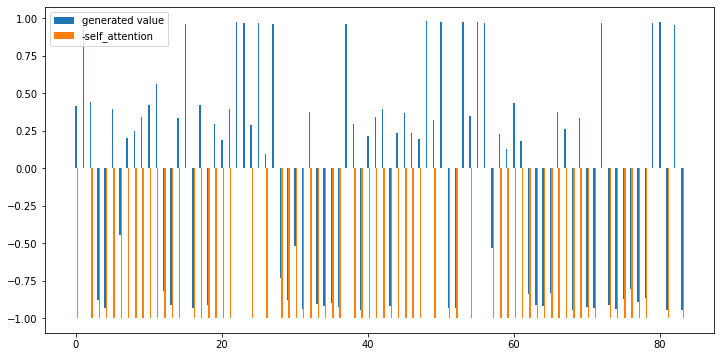

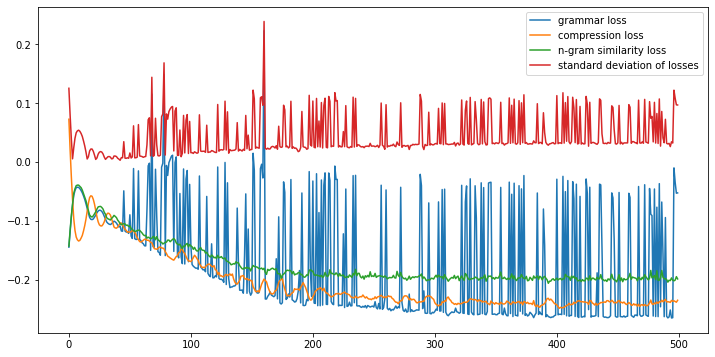

g 4.0012 	s 0.8812 	c 0.3933, score 2.4413, [The bishop of Catholic in North Dakota has exposed of church in Grand Forks and Jamestown to the hepatitis A virus early Health Department issued an advisory exposure for anyone who attended five churches communion and Bishop John (pictured) of the Fargo Dakota has potentially church Jamestown to hepatitis]
g 2.9253 	s 0.8912 	c 0.3992, score 2.2779, [The bishop Catholic in North Dakota has exposed of church in Grand Forks and Jamestown to the hepatitis A virus early Health Department issued an advisory exposure for anyone who attended five churches communion and Bishop John (pictured) of the Fargo Dakota has potentially church Jamestown to hepatitis]
g 2.9574 	s 0.8860 	c 0.4071, score 2.2860, [The bishop of Catholic in North Dakota has exposed of church in Grand Forks and Jamestown to the hepatitis A virus early Health Department issued an advisory exposure for anyone who attended five churches communion and Bishop John (pictured) of the F

('The bishop of Catholic in North Dakota has exposed church in Grand Forks and Jamestown to the hepatitis A virus early Health Department issued an advisory exposure for anyone who attended five churches communion and Bishop John (pictured) of the Fargo Dakota church Jamestown to hepatitis.',
 2.7803753542337164,
 5.753961563110352)

In [60]:
logout = True
atten_rate = 0.2
similarity = 0.5
std_factor = 3.0
txt = """
The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo Grand Forks and Jamestown to the hepatitis A.
"""
#The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bishops in Italy last month. Symptoms of hepatitis A include fever, tiredness, loss of appetite, nausea and abdominal discomfort. Fargo Catholic Diocese in North Dakota (pictured) is where the bishop is located.
#The judge agreed with police that he would have been over the limit at the time his red Citroen hit Miss Titley’s blue Daihatsu Cuore on a road near Yarmouth, Isle of Wight, on October 11, 2013. His phone records showed he was also texting around the time of the crash.

sam_wgan4(sentences_dataset[0],txt,epochs=500,display= True,retry = False,comp_rate= 1.0)

# 측정 도구...

In [47]:
!pip install rouge-score

In [48]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1','rouge2', 'rougeLsum'])

# 종합 Test

In [49]:
@@@

SyntaxError: ignored

In [51]:
!nvidia-smi

Thu Oct  7 14:51:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    32W /  70W |   4570MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import io

result_data = {}

result_data['ID'] = []
result_data['Original'] = []
result_data['Step0'] = []
result_data['Step1'] = []
result_data['Step2'] = []
result_data['Step3'] = []
result_data['Ground Truth'] = []

result_data['S0.R1'] = []
result_data['S0.R2'] = []
result_data['S0.RL'] = []
result_data['S0.Similarity'] = []
result_data['S0.Grammar'] = []

result_data['S1.R1'] = []
result_data['S1.R2'] = []
result_data['S1.RL'] = []
result_data['S1.Similarity'] = []
result_data['S1.Grammar'] = []

result_data['S2.R1'] = []
result_data['S2.R2'] = []
result_data['S2.RL'] = []
result_data['S2.Similarity'] = []
result_data['S2.Grammar'] = []

result_data['S3.R1'] = []
result_data['S3.R2'] = []
result_data['S3.RL'] = []
result_data['S3.Similarity'] = []
result_data['S3.Grammar'] = []

statistics_columns = ['S0.R1','S0.R2','S0.RL','S0.Similarity','S0.Grammar','S1.R1','S1.R2','S1.RL','S1.Similarity','S1.Grammar','S2.R1','S2.R2','S2.RL','S2.Similarity','S2.Grammar','S3.R1','S3.R2','S3.RL','S3.Similarity','S3.Grammar']

atten_rate = 0.2
similarity = 1.0
comp_rate = 1.5

std_factor = 3.0

#es = ExtactiveSummarizer()

pd.set_option('display.max_columns', 100)
cnt = 0
logout = False
for rate in range(0,1):
    
    #result_data['comp_rate'].append(comp_rate)
    for try_count in range(1000):
        
        full_text = get_prepared_doc(sentences_dataset[try_count])
        '''
        try:
            del model
            print('delete model')
        except Exception as ex:
            pass
        model = EncoderDecoderModel.from_pretrained("/content/drive/MyDrive/GAN_ENDE/en_sentence_complete_model")
        '''
        try:
        #if True:
            #org_text = besm(full_text,num_sentences=9)
            step0 = es.generate_summary(full_text,top_n=3,min_length=0)[0]

            step1 = es.generate_summary(full_text,top_n=9,min_length=0)[0]
            
            org_sentences = np.array(nltk.sent_tokenize(step1.strip()))
            if logout:
                print('BESM Summary sentance length:',len(org_sentences))
            step2,grammar,simil = summary(full_text,step1,steps=3,top_rank=3,comp_rate=comp_rate)
            tmp = []
            for txt in np.array(nltk.sent_tokenize(step2.strip())):
                tmp.append(sentence_correct(txt))         
            step3 = ' '.join(tmp)

            ground_trouth = gold_summary[try_count]
            
            print('='*50 + ' Original Document ' + str(try_count) + '='*50)
            for txt in np.array(nltk.sent_tokenize(full_text)):
                print(txt)
            print('-'*50 + ' Step0 ' + str(try_count) + '-'*50)
            for txt in np.array(nltk.sent_tokenize(step0.strip())):
                print(txt)                  
            print('-'*50 + ' Step1 ' + str(try_count) + '-'*50)
            for txt in np.array(nltk.sent_tokenize(step1.strip())):
                print(txt)                
            print('-'*50 + ' Step2 ' + str(try_count) + '-'*50)
            for txt in np.array(nltk.sent_tokenize(step2.strip())):
                print(txt)
            print('-'*50 + ' Step3 ' + str(try_count) + '-'*50)
            for txt in np.array(nltk.sent_tokenize(step3.strip())):
                print(txt)                
            print('-'*50 + ' Ground truth' + '-'*50)
            print(ground_trouth)
            print('-'*120)

            #with io.open('/content/drive/MyDrive/GAN_ENDE/CNN_Daily_summary_result.txt','a',encoding='utf8') as f:
            #    f.write(org_text + '\r\n\r\n')
            s0_rouge = scorer.score(ground_trouth,step0)            
            s1_rouge = scorer.score(ground_trouth,step1)
            s2_rouge = scorer.score(ground_trouth,step2)
            s3_rouge = scorer.score(ground_trouth,step3)
            s0_simil = similarity3(full_text,step0)            
            s1_simil = similarity3(full_text,step1)
            s2_simil = similarity3(full_text,step2)
            s3_simil = similarity3(full_text,step3)
            s0_gramm = grammar3(full_text,step0)            
            s1_gramm = grammar3(full_text,step1)
            s2_gramm = grammar3(full_text,step2) 
            s3_gramm = grammar3(full_text,step3)  
            #print(scores['rouge1'].fmeasure)
            if s1_rouge['rouge1'].fmeasure > 0.1:

                result_data['ID'].append('CNN/DM-'+str(try_count))
                result_data['Original'].append(full_text)
                result_data['Step0'].append(step1)
                result_data['Step1'].append(step1)
                result_data['Step2'].append(step2)
                result_data['Step3'].append(step3)
                result_data['Ground Truth'].append(ground_trouth)

                result_data['S0.R1'].append(s0_rouge['rouge1'].fmeasure)
                result_data['S0.R2'].append(s0_rouge['rouge2'].fmeasure)
                result_data['S0.RL'].append(s0_rouge['rougeL'].fmeasure)
                result_data['S0.Similarity'].append(s0_simil)
                result_data['S0.Grammar'].append(s0_gramm)

                result_data['S1.R1'].append(s1_rouge['rouge1'].fmeasure)
                result_data['S1.R2'].append(s1_rouge['rouge2'].fmeasure)
                result_data['S1.RL'].append(s1_rouge['rougeL'].fmeasure)
                result_data['S1.Similarity'].append(s1_simil)
                result_data['S1.Grammar'].append(s1_gramm)

                result_data['S2.R1'].append(s2_rouge['rouge1'].fmeasure)
                result_data['S2.R2'].append(s2_rouge['rouge2'].fmeasure)
                result_data['S2.RL'].append(s2_rouge['rougeL'].fmeasure)
                result_data['S2.Similarity'].append(s2_simil)
                result_data['S2.Grammar'].append(s2_gramm)

                result_data['S3.R1'].append(s3_rouge['rouge1'].fmeasure)
                result_data['S3.R2'].append(s3_rouge['rouge2'].fmeasure)
                result_data['S3.RL'].append(s3_rouge['rougeL'].fmeasure)
                result_data['S3.Similarity'].append(s3_simil)
                result_data['S3.Grammar'].append(s3_gramm)

            print()
            df_result_data = pd.DataFrame(result_data)
            print(df_result_data[statistics_columns].iloc[-1])
            print()
            df_mean = df_result_data[statistics_columns].mean()
            print('** Mean result **')
            print(df_mean)
            del df_mean
            del df_result_data

            cnt+=1
            if cnt > 100:
                break                
        except Exception as ex:
            print(ex)

print('** Total mean result **')
df_result_data = pd.DataFrame(result_data)
df_mean = df_result_data[statistics_columns].mean()
print(df_mean)
df_result_data.to_pickle("/content/drive/MyDrive/GAN_ENDE/df_result_93.pkl")

df_result_data[['ID']+statistics_columns]

In [ ]:
import io

result_data = {}

result_data['ID'] = []
result_data['Original'] = []
result_data['Step0'] = []
result_data['Step1'] = []
result_data['Step2'] = []
result_data['Step3'] = []
result_data['Ground Truth'] = []

result_data['S0.R1'] = []
result_data['S0.R2'] = []
result_data['S0.RL'] = []
result_data['S0.Similarity'] = []
result_data['S0.Grammar'] = []

result_data['S1.R1'] = []
result_data['S1.R2'] = []
result_data['S1.RL'] = []
result_data['S1.Similarity'] = []
result_data['S1.Grammar'] = []

result_data['S2.R1'] = []
result_data['S2.R2'] = []
result_data['S2.RL'] = []
result_data['S2.Similarity'] = []
result_data['S2.Grammar'] = []

result_data['S3.R1'] = []
result_data['S3.R2'] = []
result_data['S3.RL'] = []
result_data['S3.Similarity'] = []
result_data['S3.Grammar'] = []

statistics_columns = ['S0.R1','S0.R2','S0.RL','S0.Similarity','S0.Grammar','S1.R1','S1.R2','S1.RL','S1.Similarity','S1.Grammar','S2.R1','S2.R2','S2.RL','S2.Similarity','S2.Grammar','S3.R1','S3.R2','S3.RL','S3.Similarity','S3.Grammar']

atten_rate = 0.2
similarity = 1.0
comp_rate = 1.5

std_factor = 3.0

#es = ExtactiveSummarizer()

pd.set_option('display.max_columns', 100)
cnt = 0
logout = False
for rate in range(0,1):
    
    #result_data['comp_rate'].append(comp_rate)
    for try_count in range(1000):
        
        full_text = get_prepared_doc(sentences_dataset[try_count])
        '''
        try:
            del model
            print('delete model')
        except Exception as ex:
            pass
        model = EncoderDecoderModel.from_pretrained("/content/drive/MyDrive/GAN_ENDE/en_sentence_complete_model")
        '''
        try:

            #org_text = besm(full_text,num_sentences=9)
            step0 = es.generate_summary(full_text,top_n=3,min_length=0)[0]

            step1 = es.generate_summary(full_text,top_n=6,min_length=0)[0]
            
            org_sentences = np.array(nltk.sent_tokenize(step1.strip()))
            if logout:
                print('BESM Summary sentance length:',len(org_sentences))
            step2,grammar,simil = summary(full_text,step1,steps=2,top_rank=2,comp_rate=comp_rate)
            tmp = []
            for txt in np.array(nltk.sent_tokenize(step2.strip())):
                tmp.append(sentence_correct(txt))         
            step3 = ' '.join(tmp)

            ground_trouth = gold_summary[try_count]
            
            print('='*50 + ' Original Document ' + str(try_count) + '='*50)
            for txt in np.array(nltk.sent_tokenize(full_text)):
                print(txt)
            print('-'*50 + ' Step0 ' + str(try_count) + '-'*50)
            for txt in np.array(nltk.sent_tokenize(step0.strip())):
                print(txt)                  
            print('-'*50 + ' Step1 ' + str(try_count) + '-'*50)
            for txt in np.array(nltk.sent_tokenize(step1.strip())):
                print(txt)                
            print('-'*50 + ' Step2 ' + str(try_count) + '-'*50)
            for txt in np.array(nltk.sent_tokenize(step2.strip())):
                print(txt)
            print('-'*50 + ' Step3 ' + str(try_count) + '-'*50)
            for txt in np.array(nltk.sent_tokenize(step3.strip())):
                print(txt)                
            print('-'*50 + ' Ground truth' + '-'*50)
            print(ground_trouth)
            print('-'*120)

            #with io.open('/content/drive/MyDrive/GAN_ENDE/CNN_Daily_summary_result.txt','a',encoding='utf8') as f:
            #    f.write(org_text + '\r\n\r\n')
            s0_rouge = scorer.score(ground_trouth,step0)            
            s1_rouge = scorer.score(ground_trouth,step1)
            s2_rouge = scorer.score(ground_trouth,step2)
            s3_rouge = scorer.score(ground_trouth,step3)
            s0_simil = similarity3(full_text,step0)            
            s1_simil = similarity3(full_text,step1)
            s2_simil = similarity3(full_text,step2)
            s3_simil = similarity3(full_text,step3)
            s0_gramm = grammar3(full_text,step0)            
            s1_gramm = grammar3(full_text,step1)
            s2_gramm = grammar3(full_text,step2) 
            s3_gramm = grammar3(full_text,step3)  
            #print(scores['rouge1'].fmeasure)
            if s1_rouge['rouge1'].fmeasure > 0.1:

                result_data['ID'].append('CNN/DM-'+str(try_count))
                result_data['Original'].append(full_text)
                result_data['Step0'].append(step1)
                result_data['Step1'].append(step1)
                result_data['Step2'].append(step2)
                result_data['Step3'].append(step3)
                result_data['Ground Truth'].append(ground_trouth)

                result_data['S0.R1'].append(s0_rouge['rouge1'].fmeasure)
                result_data['S0.R2'].append(s0_rouge['rouge2'].fmeasure)
                result_data['S0.RL'].append(s0_rouge['rougeL'].fmeasure)
                result_data['S0.Similarity'].append(s0_simil)
                result_data['S0.Grammar'].append(s0_gramm)

                result_data['S1.R1'].append(s1_rouge['rouge1'].fmeasure)
                result_data['S1.R2'].append(s1_rouge['rouge2'].fmeasure)
                result_data['S1.RL'].append(s1_rouge['rougeL'].fmeasure)
                result_data['S1.Similarity'].append(s1_simil)
                result_data['S1.Grammar'].append(s1_gramm)

                result_data['S2.R1'].append(s2_rouge['rouge1'].fmeasure)
                result_data['S2.R2'].append(s2_rouge['rouge2'].fmeasure)
                result_data['S2.RL'].append(s2_rouge['rougeL'].fmeasure)
                result_data['S2.Similarity'].append(s2_simil)
                result_data['S2.Grammar'].append(s2_gramm)

                result_data['S3.R1'].append(s3_rouge['rouge1'].fmeasure)
                result_data['S3.R2'].append(s3_rouge['rouge2'].fmeasure)
                result_data['S3.RL'].append(s3_rouge['rougeL'].fmeasure)
                result_data['S3.Similarity'].append(s3_simil)
                result_data['S3.Grammar'].append(s3_gramm)

            print()
            df_result_data = pd.DataFrame(result_data)
            print(df_result_data[statistics_columns].iloc[-1])
            print()
            df_mean = df_result_data[statistics_columns].mean()
            print('** Mean result **')
            print(df_mean)
            del df_mean
            del df_result_data

            cnt+=1
            if cnt > 100:
                break            
        except Exception as ex:
            print(ex)

print('** Total mean result **')
df_result_data = pd.DataFrame(result_data)
df_mean = df_result_data[statistics_columns].mean()
print(df_mean)
df_result_data.to_pickle("/content/drive/MyDrive/GAN_ENDE/df_result_93.pkl")

df_result_data[['ID']+statistics_columns]

In [66]:
import io

result_data = {}

result_data['ID'] = []
result_data['Original'] = []
result_data['Step0'] = []
result_data['Step1'] = []
result_data['Step2'] = []
result_data['Step3'] = []
result_data['Ground Truth'] = []

result_data['S0.R1'] = []
result_data['S0.R2'] = []
result_data['S0.RL'] = []
result_data['S0.Similarity'] = []
result_data['S0.Grammar'] = []

result_data['S1.R1'] = []
result_data['S1.R2'] = []
result_data['S1.RL'] = []
result_data['S1.Similarity'] = []
result_data['S1.Grammar'] = []

result_data['S2.R1'] = []
result_data['S2.R2'] = []
result_data['S2.RL'] = []
result_data['S2.Similarity'] = []
result_data['S2.Grammar'] = []

result_data['S3.R1'] = []
result_data['S3.R2'] = []
result_data['S3.RL'] = []
result_data['S3.Similarity'] = []
result_data['S3.Grammar'] = []

statistics_columns = ['S0.R1','S0.R2','S0.RL','S0.Similarity','S0.Grammar','S1.R1','S1.R2','S1.RL','S1.Similarity','S1.Grammar','S2.R1','S2.R2','S2.RL','S2.Similarity','S2.Grammar','S3.R1','S3.R2','S3.RL','S3.Similarity','S3.Grammar']

atten_rate = 0.2
similarity = 0.5
comp_rate = 1.0

std_factor = 3.0

#es = ExtactiveSummarizer()

pd.set_option('display.max_columns', 100)
cnt = 0
logout = False
for rate in range(0,1):
    
    #result_data['comp_rate'].append(comp_rate)
    for try_count in range(1000):
        
        full_text = get_prepared_doc(sentences_dataset[try_count])
        '''
        try:
            del model
            print('delete model')
        except Exception as ex:
            pass
        model = EncoderDecoderModel.from_pretrained("/content/drive/MyDrive/GAN_ENDE/en_sentence_complete_model")
        '''
        try:
        #if True:
            #org_text = besm(full_text,num_sentences=9)
            step0 = lead(full_text,top_n=3)

            step1 = lead(full_text,top_n=9)
            
            org_sentences = np.array(nltk.sent_tokenize(step1.strip()))
            if logout:
                print('BESM Summary sentance length:',len(org_sentences))
            step2,grammar,simil = summary(full_text,step1,steps=3,top_rank=3,comp_rate=comp_rate)
            tmp = []
            for txt in np.array(nltk.sent_tokenize(step2.strip())):
                tmp.append(sentence_correct(txt))         
            step3 = ' '.join(tmp)

            ground_trouth = gold_summary[try_count]
            
            print('='*50 + ' Original Document ' + str(try_count) + '='*50)
            for txt in np.array(nltk.sent_tokenize(full_text)):
                print(txt)
            print('-'*50 + ' Step0 ' + str(try_count) + '-'*50)
            for txt in np.array(nltk.sent_tokenize(step0.strip())):
                print(txt)                  
            print('-'*50 + ' Step1 ' + str(try_count) + '-'*50)
            for txt in np.array(nltk.sent_tokenize(step1.strip())):
                print(txt)                
            print('-'*50 + ' Step2 ' + str(try_count) + '-'*50)
            for txt in np.array(nltk.sent_tokenize(step2.strip())):
                print(txt)
            print('-'*50 + ' Step3 ' + str(try_count) + '-'*50)
            for txt in np.array(nltk.sent_tokenize(step3.strip())):
                print(txt)                
            print('-'*50 + ' Ground truth' + '-'*50)
            print(ground_trouth)
            print('-'*120)

            #with io.open('/content/drive/MyDrive/GAN_ENDE/CNN_Daily_summary_result.txt','a',encoding='utf8') as f:
            #    f.write(org_text + '\r\n\r\n')
            s0_rouge = scorer.score(ground_trouth,step0)            
            s1_rouge = scorer.score(ground_trouth,step1)
            s2_rouge = scorer.score(ground_trouth,step2)
            s3_rouge = scorer.score(ground_trouth,step3)
            s0_simil = similarity3(full_text,step0)            
            s1_simil = similarity3(full_text,step1)
            s2_simil = similarity3(full_text,step2)
            s3_simil = similarity3(full_text,step3)
            s0_gramm = grammar3(full_text,step0)            
            s1_gramm = grammar3(full_text,step1)
            s2_gramm = grammar3(full_text,step2) 
            s3_gramm = grammar3(full_text,step3)  
            #print(scores['rouge1'].fmeasure)
            if s1_rouge['rouge1'].fmeasure > 0.1:

                result_data['ID'].append('CNN/DM-'+str(try_count))
                result_data['Original'].append(full_text)
                result_data['Step0'].append(step1)
                result_data['Step1'].append(step1)
                result_data['Step2'].append(step2)
                result_data['Step3'].append(step3)
                result_data['Ground Truth'].append(ground_trouth)

                result_data['S0.R1'].append(s0_rouge['rouge1'].fmeasure)
                result_data['S0.R2'].append(s0_rouge['rouge2'].fmeasure)
                result_data['S0.RL'].append(s0_rouge['rougeLsum'].fmeasure)
                result_data['S0.Similarity'].append(s0_simil)
                result_data['S0.Grammar'].append(s0_gramm)

                result_data['S1.R1'].append(s1_rouge['rouge1'].fmeasure)
                result_data['S1.R2'].append(s1_rouge['rouge2'].fmeasure)
                result_data['S1.RL'].append(s1_rouge['rougeLsum'].fmeasure)
                result_data['S1.Similarity'].append(s1_simil)
                result_data['S1.Grammar'].append(s1_gramm)

                result_data['S2.R1'].append(s2_rouge['rouge1'].fmeasure)
                result_data['S2.R2'].append(s2_rouge['rouge2'].fmeasure)
                result_data['S2.RL'].append(s2_rouge['rougeLsum'].fmeasure)
                result_data['S2.Similarity'].append(s2_simil)
                result_data['S2.Grammar'].append(s2_gramm)

                result_data['S3.R1'].append(s3_rouge['rouge1'].fmeasure)
                result_data['S3.R2'].append(s3_rouge['rouge2'].fmeasure)
                result_data['S3.RL'].append(s3_rouge['rougeLsum'].fmeasure)
                result_data['S3.Similarity'].append(s3_simil)
                result_data['S3.Grammar'].append(s3_gramm)

            print()
            df_result_data = pd.DataFrame(result_data)
            print(df_result_data[statistics_columns].iloc[-1])
            print()
            df_mean = df_result_data[statistics_columns].mean()
            print('** Mean result **')
            print(df_mean)
            del df_mean
            del df_result_data

            cnt+=1
            if cnt > 100:
                break            
        except Exception as ex:
            print(ex)

print('** Total mean result **')
df_result_data = pd.DataFrame(result_data)
df_mean = df_result_data[statistics_columns].mean()
print(df_mean)
df_result_data.to_pickle("/content/drive/MyDrive/GAN_ENDE/df_result_93.pkl")

df_result_data[['ID']+statistics_columns]

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
================================================== Original Document 51==================================================
Rafael Benitez has received fresh criticism of his waistline ahead of Napoli's crucial Serie A fixture with Sampdoria this weekend, as the quest for a UEFA Champions League place reaches a crescendo in Italy.
The Spaniard has been linked with the managerial job at Sampdoria after it emerged that Sinisa Mihajlovic - the current Blucerchiati boss - is being lined up to replace Benitez at Napoli.
But Sampdoria president Massimo Ferrero has taken inspiration from a favourite chant of the Goodison Park and Old Trafford terraces, appearing to quash rumours that a job swap is imminent.
Napoli manager Rafael Benitez jokes with Switzerland Gokhan Inler (right) during a training session.
Benitez challenges Argentinian forward Gonzalo Higuain during a training session earlier today.
'I could take Benitez, but I'd have to take him to see a di

IndexError: ignored